# Análise de Grafo Logístico
Este notebook realiza a leitura de dados de uma instância de grafo logístico, calcula estatísticas básicas e exibe uma visualização do grafo com distinção entre arestas obrigatórias e não obrigatórias.

---

## 1. Importação de Bibliotecas

Antes de tudo, importamos as bibliotecas necessárias e funções auxiliares responsáveis pela leitura dos dados e cálculo de estatísticas do grafo.

In [534]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math
import random
from src.analise_grafo import ler_arquivo_dados, calcular_estatisticas

## 2. Leitura do Arquivo de Dados

Nesta etapa, utilizamos a função `ler_arquivo_dados()` para ler o conteúdo do arquivo de entrada contendo as informações do grafo. Essa função retorna um dicionário com listas separadas para arestas obrigatórias e não obrigatórias, além do número total de nós presentes na instância.

In [535]:
caminho_arquivo = "dados/teste.dat"
dados_grafo, total_nos = ler_arquivo_dados(caminho_arquivo)


# 3. Cálculo das Estatísticas do Grafo

Com os dados carregados, utilizamos a função `calcular_estatisticas()` para extrair informações importantes sobre a estrutura do grafo, como número de vértices, quantidade de arestas, grau mínimo/máximo e densidade. Essas estatísticas ajudam a entender melhor as características do problema.

In [536]:
estatisticas = calcular_estatisticas(dados_grafo, total_nos)

for chave, valor in estatisticas.items():
    print(f"{chave}: {valor}")



Estatísticas do Grafo:
1- Quantidade de vértices: 50
2- Quantidade de arestas: 32
3- Quantidade de arcos: 100
4- Quantidade de vértices obrigatórios: 39
5- Quantidade de arestas obrigatórias: 16
6- Quantidade de arcos obrigatórios: 50
7- É direcionado?: True
8- Densidade: 0.04081632653061224
9- Grau mínimo: 0
10- Grau máximo: 3
11- Intermedição: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 15, 11: 19, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 13, 18: 12, 19: 7, 20: 0, 21: 5, 22: 0, 23: 8, 24: 2, 25: 5, 26: 12, 27: 0, 28: 28, 29: 10, 30: 0, 31: 0, 32: 0, 33: 0, 34: 5, 35: 12, 36: 33, 37: 0, 38: 0, 39: 1, 40: 0, 41: 0, 42: 0, 43: 10, 44: 18, 45: 10, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0}
12- Caminho Médio: 9.565891472868216
13- Diâmetro: 28


## 4. Posicionamento dos nós no espaço (visualização das interseções)

Aqui, cada ponto (ou nó) do grafo recebe uma posição no plano 2D para podermos visualizar o grafo como se fosse um mapa.

### Qual o objetivo?

Como os nós representam cruzamentos ou locais importantes, posicioná-los no plano ajuda a montar uma visão geral da rede de ruas. Isso facilita entender como as ruas estão conectadas e por onde os veículos podem circular.

### Como fizemos isso?

Geramos coordenadas aleatórias para cada nó dentro de uma área delimitada. Assim, conseguimos desenhar os pontos de forma distribuída, sem que fiquem colados nas bordas.

Mesmo sendo uma distribuição aleatória, ela já é suficiente para termos uma noção geral da estrutura do grafo e conseguirmos visualizar as conexões entre os nós depois.


In [537]:
largura = 10
altura = 10
margem = 1.5  # margem para evitar que fiquem na borda

posicoes = {}

for no in range(1, total_nos + 1):
    x = random.uniform(margem, largura - margem)
    y = random.uniform(margem, altura - margem)
    posicoes[no] = (x, y)


## 5. Visualização do grafo com cores específicas

Nesta parte, mostramos visualmente o grafo com as ruas e cruzamentos representados como conexões (arestas/arcos) e nós. A ideia é facilitar o entendimento das vias que precisam ou não ser percorridas no problema, além de deixar claro quando uma rua é mão única ou dupla.

### Como representamos as vias (ligações entre os nós):

- **Arestas obrigatórias (REE)**: São as ruas que devem ser atendidas e são de mão dupla. Aparecem como **linhas azuis sólidas**.
- **Arestas opcionais (EDGE)**: Ruas de mão dupla que podem ser usadas se forem vantajosas. Mostradas como **linhas ciano tracejadas**.
- **Arcos obrigatórios (REA)**: São vias obrigatórias de **mão única**. Aparecem como **setas verdes sólidas**.
- **Arcos opcionais (ARC)**: Vias de mão única que podem ser usadas ou não. Representadas por **setas roxas tracejadas**.

Cada via mostra também o seu **custo** (distância, tempo ou esforço para percorrer), indicado no meio da linha com um número.

### E os pontos (nós) do grafo:

- **Nós obrigatórios (REN)**: Representam locais que precisam ser visitados (como pontos de coleta). Aparecem como **círculos azul escuro** com o número branco no centro.
- **Nós opcionais**: São cruzamentos ou intersecções que podem ser usados apenas para passar. Aparecem como **círculos azul acinzentado**.

### Por que isso ajuda?

Essa visualização torna muito mais fácil:
- Ver quais ruas são mais importantes;
- Distinguir mão única de mão dupla;
- Entender como os custos estão distribuídos;
- Ter uma base clara para pensar em boas rotas.

Com isso, a estrutura do problema fica bem visível, e conseguimos partir para as próximas etapas com mais clareza.


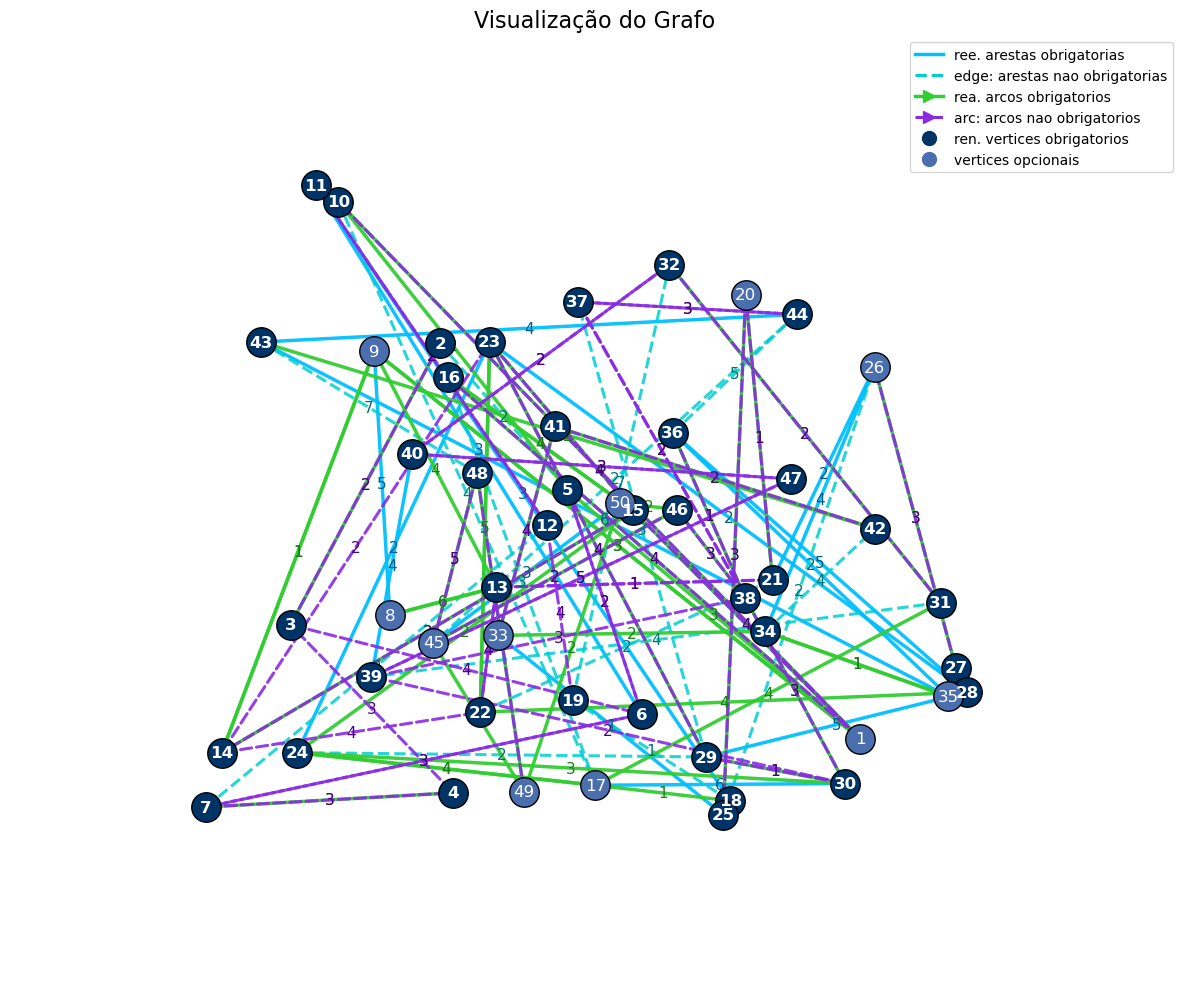

In [538]:
fig, ax = plt.subplots(figsize=(12, 10))

# arestas obrigatorias: azul elétrico
for de_no, para_no, custo, *_ in dados_grafo.get('arestas_obrigatorias', []):
    x1, y1 = posicoes[de_no]; x2, y2 = posicoes[para_no]
    ax.plot([x1, x2], [y1, y2],
            color='#00BFFF', linewidth=2.5, alpha=0.95, zorder=1)
    mx, my = (x1 + x2)/2, (y1 + y2)/2
    ax.text(mx, my, f'{custo}',
            color='#005c87', fontsize=11, ha='center', va='center', zorder=2)

# arestas nao obrigatorias: ciano claro tracejado
for de_no, para_no, custo in dados_grafo.get('arestas_nao_obrigatorias', []):
    x1, y1 = posicoes[de_no]; x2, y2 = posicoes[para_no]
    ax.plot([x1, x2], [y1, y2],
            color='#00CED1', linestyle='--', linewidth=2.2, alpha=0.85, zorder=1)
    mx, my = (x1 + x2)/2, (y1 + y2)/2
    ax.text(mx, my, f'{custo}',
            color='#007374', fontsize=11, ha='center', va='center', zorder=2)

# arcos obrigatorios: verde neon com seta
for de_no, para_no, custo, *_ in dados_grafo.get('arcos_obrigatorios', []):
    x1, y1 = posicoes[de_no]; x2, y2 = posicoes[para_no]
    ax.annotate("",
        xy=(x2, y2), xytext=(x1, y1),
        arrowprops=dict(arrowstyle="->", color='#32CD32', linewidth=2.5, alpha=0.95),
        zorder=1
    )
    mx, my = (x1 + x2)/2, (y1 + y2)/2
    ax.text(mx, my, f'{custo}',
            color='#1a7f1a', fontsize=11, ha='center', va='center', zorder=2)

# arcos nao obrigatorios: roxo neon tracejado com seta
for de_no, para_no, custo in dados_grafo.get('arcos_nao_obrigatorios', []):
    x1, y1 = posicoes[de_no]; x2, y2 = posicoes[para_no]
    ax.annotate("",
        xy=(x2, y2), xytext=(x1, y1),
        arrowprops=dict(arrowstyle="->", linestyle='--', color='#8A2BE2', linewidth=2.2, alpha=0.9),
        zorder=1
    )
    mx, my = (x1 + x2)/2, (y1 + y2)/2
    ax.text(mx, my, f'{custo}',
            color='#4b0082', fontsize=11, ha='center', va='center', zorder=2)

# vertices obrigatorios: azul escuro
for no in dados_grafo['nos']:
    x, y = posicoes[no]
    ax.scatter(x, y, color='#003366', s=450, edgecolors='black', zorder=3)
    ax.text(x, y, str(no),
            fontsize=12, ha='center', va='center', color='white', weight='bold', zorder=4)

# vertices opcionais: azul acinzentado
vertices_todos = set(range(1, total_nos+1))
vertices_obrigatorios = set(dados_grafo['nos'].keys())
vertices_opcionais = vertices_todos - vertices_obrigatorios

for no in vertices_opcionais:
    x, y = posicoes[no]
    ax.scatter(x, y, color='#4B6EAF', s=450, edgecolors='black', zorder=3)
    ax.text(x, y, str(no),
            fontsize=12, ha='center', va='center', color='white', zorder=4)

# estetica
ax.set_title("Visualização do Grafo", fontsize=16)
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim(0, largura); ax.set_ylim(0, altura)
ax.set_frame_on(False)

# legenda
legenda = [
    Line2D([], [], color='#00BFFF', lw=2.5, label='ree. arestas obrigatorias'),
    Line2D([], [], color='#00CED1', lw=2.2, linestyle='--', label='edge: arestas nao obrigatorias'),
    Line2D([], [], color='#32CD32', lw=2.5, label='rea. arcos obrigatorios', marker='>', markersize=8),
    Line2D([], [], color='#8A2BE2', lw=2.2, linestyle='--', label='arc: arcos nao obrigatorios', marker='>', markersize=8),
    Line2D([], [], marker='o', color='#003366', label='ren. vertices obrigatorios',
           markerfacecolor='#003366', markersize=10, linestyle='None'),
    Line2D([], [], marker='o', color='#4B6EAF', label='vertices opcionais',
           markerfacecolor='#4B6EAF', markersize=10, linestyle='None'),
]

ax.legend(handles=legenda, loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


## ✅ 6. Conclusão

Ao destacar esses nós, conseguimos identificar com clareza:

- Onde o serviço é obrigatório (e, portanto, precisa de planejamento),
- Onde os veículos podem passar apenas para facilitar o trajeto.
